# Wavelet results classification

## Occipital classification

### step 1 load data_occipital

In [1]:
%pylab inline
import sklearn
from scipy.io import loadmat
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from scipy.ndimage.interpolation import shift

Populating the interactive namespace from numpy and matplotlib


In [2]:
#load in the final data: all subject,all levels, all orientations;
#data = np.load('data_all_subjects_final_log_BA17.npy')
data = np.load('allsubjs_vstacked_readyfor_classification_occipital_zscored.npy')

In [15]:
data.shape 

(512, 5, 28, 8)

512 is all TRs, 5 is 5 levels, 28 orientation, 8 subjects.

In [10]:
#load in all the labels/conditions
subj_lst = ["s1","s2","s3","s5","s6","s7","s8","s10"]
conditions_lst = []

for subject in tqdm(subj_lst):
    
    conditions = loadmat(subject+'/conds_short_tlrc.mat')
    conditions = conditions['conds_short_tlrc']
    conditions_sh2 = shift(conditions,[0,2], cval=0) #shift by 2 TRs
    
    def convert_binary_to_multiclass(binary_conditions):
        """Convert binary representation into multiclass reprentation:
        For example: convert [[1 1 1 1 0 0 0 0]
                              [0 0 0 0 1 1 1 1]]
        to [1 1 1 1 2 2 2 2]"""
        x,y = np.where(binary_conditions)
        conditions=np.zeros(binary_conditions.shape[1])
        conditions[y]=x+1
        return conditions

    conditions_multi = convert_binary_to_multiclass(conditions_sh2)
    
    conditions_lst.append(conditions_multi)


100%|██████████| 8/8 [00:00<00:00, 471.03it/s]


In [11]:
conditions_final = np.vstack (conditions_lst)

In [16]:
conditions_final.shape

(8, 512)

In [7]:
np.save ("conditions_sh2_final.npy", conditions_final)

In [17]:
# Then I label all the conditions
face = conditions_multi == 1
objects = conditions_multi == 2
place = conditions_multi == 3
fruit = conditions_multi == 4

## Classification analysis


In [19]:
labels = conditions_final.reshape(4096,1)
labels.shape

(4096, 1)

In [20]:
no_res = labels!=0
no_res = no_res.reshape(512*8)# because I will use this as mask, so there is no ',1' in shape

In [21]:
labels_no_res = labels[no_res]
labels_no_res.shape

(1536, 1)

### Classification 06/29/2020

In [137]:
subject = 0 

level = 0

#animals = [1,2,3,4,5,6,7,8,9,10,11,12] # represent all the animals in 3 categories

run = 0


In [138]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

def wavefunc (subject, level, run): 
    """This function calculate each subject, each level,and using leaving one run out cross-validation 
        method for classification. Subjects are from 0-7; levels are from 0-4. For example, wavefunc (0,3,0)"""
    # First I will start with one subject. 

    subj_data = data[:,:,:,subject] # First choose one subject data
    subj_labels = conditions_final[subject,:]

    level_data = subj_data[:,level,:] # Then choose one level data

    #level_data.shape
   # choose the masks corresponding to each category in the pair
    #mask_1 = np.in1d (conditions_multi, animals)# np.in1d you need to make sure what shape you want, the shape you want should be put as the first element.
    #mask_2 = np.in1d (conditions_multi, animals)
    
    # Choose one run data according to the animal pair 
    tr_index = np.arange(512)
    # Each run has 32TRs, to choose the first run, will use the logic below
    #run_mask = np.logical_and(run*128 <= tr_index, tr_index < (run+1)*128) # instead of using leave-one-run-out, so run here is equivalent to folds
    run_mask = np.logical_and(run*32 <= tr_index, tr_index < (run+1)*32) # instead of using leave-one-run-out, so run here is equivalent to folds

    no_res_mask = subj_labels!= 0 
    #print run_mask.shape
    # Select the data by applying the mask
    # category_mask = np.logical_or(mask_1, mask_2)
    # category_mask = category_mask.reshape(1230)

    test_mask = np.logical_and(no_res_mask, run_mask) # choose the category pair and one run data
    train_mask = np.logical_and(no_res_mask,~run_mask) # ~ means invert mask, mean except that mask; choose the animal pairs and other 9 runs data

    #test_data =  level_data[test_mask,:]
    #train_data = level_data[train_mask,:]

    #Next generate the features matrix and label matrix to prep for the classification.
    labels_test = subj_labels[test_mask] # choose the category pair and run masks within all the conditions. test labels
    #labels_test =  (labels_test -1) // 4 # which convert 1-12 to "0,0,0,0, 1,1,1,1,2,2,2,2"
    features_test = level_data [test_mask,:] # test features

    labels_train = subj_labels[train_mask]
    #labels_train =  (labels_train -1) // 4
    features_train = level_data [train_mask,:]

    # Now we can run classification
    #scaler = StandardScaler()

    X_train, X_test = features_train, features_test
    y_train, y_test = labels_train, labels_test
    
    #import pdb ; pdb.set_trace()# stop here to debug
    #X_train_scaler =  scaler.fit_transform (X_train)
    #X_test_scaler=  scaler.transform (X_test)
    
    #Train the model using the training sets
    #model = svm.SVC()
    #model = KNeighborsClassifier(n_neighbors=10) 
    #model = GaussianNB()
    model = XGBClassifier(objective = 'multi:softmax')
    #model = XGBClassifier(silent=False, 
                      #scale_pos_weight=1,
                      #learning_rate=0.01,  
                      #colsample_bytree = 0.4,
                      #subsample = 0.8,
                      #objective='multi:softmax', 
                      #n_estimators=1000, 
                      #reg_alpha = 0.3,
                      #max_depth=4, 
                      #gamma=10)
    model.fit(X_train,y_train)# model fit traning set.

    #Predict Output
    prediction_x_train = model.predict(X_train)
    predicted = model.predict(X_test) # 0:Overcast, 2:Mild
    
    #shufffle blocks only 
    test_shuffle = []
    blocks = np.array([1,2,3,4])
    for s in range(10000):
        blocks_shuffled = blocks.copy()
        np.random.shuffle(blocks_shuffled)
        blocks_shuffled = np.repeat(blocks_shuffled,3)
        acc_shuffled = accuracy_score(blocks_shuffled, predicted)
        test_shuffle.append(acc_shuffled)
    #Method2: shuffled all TRs within the run.
    #test_shuffle = []
    #for s in range(10000):
        #y_test_shuffled = y_test.copy()
        #np.random.shuffle(y_test_shuffled)
        #import pdb ; pdb.set_trace()# stop here to debug
        #acc_shuffled = accuracy_score(y_test_shuffled, predicted)
        #test_shuffle.append(acc_shuffled)
    acc = accuracy_score(y_test, predicted)
    
    #return acc
    return acc,np.array(test_shuffle)
    #return acc,y_test,predicted, prediction_x_train,y_train

    #now we have one run data for testing, we need 9 runs data set for training.


In [69]:
test = [1,2,3,4]
np.repeat(test,3)

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])

In [68]:
wavefunc(0,0,0)

> <ipython-input-67-4faa85b02c47>(62)wavefunc()
-> model = XGBClassifier(objective = 'multi:softmax')
(Pdb) y_test.shape
(12,)
(Pdb) print (y_test)
[1. 1. 1. 3. 3. 3. 4. 4. 4. 2. 2. 2.]
(Pdb) q


BdbQuit: 

In [190]:
y_test_lst = []
predic_lst = []
predic_x_train_lst = []
y_train_lst = []
for i in range (8):
    acc, y_test, prediction, prediction_x_train,y_train = wavefunc(i,3,0)
    y_test_lst.append (y_test)
    predic_lst.append(prediction)
    predic_x_train_lst.append(prediction_x_train)
    y_train_lst.append(y_train)   

In [191]:
y_test = np.hstack(y_test_lst)
prediction = np.hstack(predic_lst)
prediction_x_train = np.hstack(predic_x_train_lst)
y_train = np.hstack(y_train_lst)

In [104]:
y_train.shape

(1152,)

In [105]:
#acc, y_test, prediction, prediction_x_train,y_train = wavefunc (3,3,0)

[Text(0,0,'1'), Text(0,0,'2'), Text(0,0,'3'), Text(0,0,'4')]

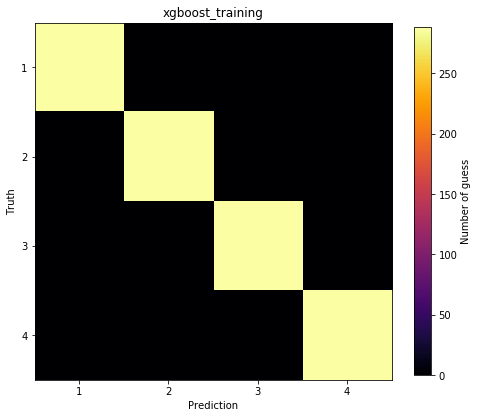

In [107]:
cm = confusion_matrix(y_train, prediction_x_train)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap = "inferno")
plt.colorbar(shrink=0.8).set_label('Number of guess')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.title('xgboost_training')
plt.xticks(np.arange(4))
plt.gca().set_xticklabels(np.arange(1,5))
plt.yticks(np.arange(4))
plt.gca().set_yticklabels(np.arange(1,5))
# plt.xticks(np.arange(1,13))
plt.savefig('training_v1_L1.png')
#ax.plot([0, 1], [0, 1], transform=ax.transAxes)

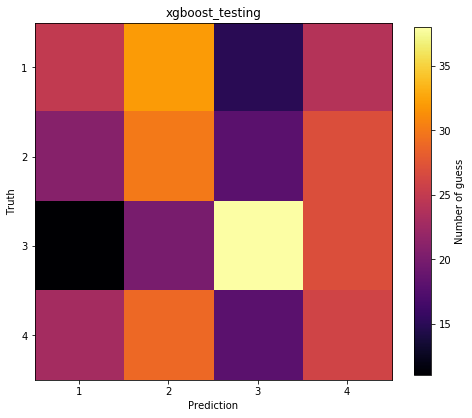

In [192]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap = "inferno")
plt.colorbar(shrink=0.8).set_label('Number of guess')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.title('xgboost_testing')
plt.xticks(np.arange(4))
plt.gca().set_xticklabels(np.arange(1,5))
plt.yticks(np.arange(4))
plt.gca().set_yticklabels(np.arange(1,5))
# plt.xticks(np.arange(1,13))
plt.savefig('testing_vt_L3.png')
#ax.plot([0, 1], [0, 1], transform=ax.transAxes)

In [36]:
def wavefunc_cross_validation (subject, level):
    """ This function is just the wavefunc with cross-validation built-in"""   
    acc = []
    for i in range(4):
        acc.append(wavefunc(subject,level,i))

    acc =  np.asarray(acc)
    return acc.mean()

In [98]:
a = wavefunc (1, 2, 1)
print (a.shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [37]:
# Now I would like to loop over all the subjects, all the levels, and all the category pairs.

subjects = np.arange(8) # 8 subjects.

levels = np.arange (5) # 0-4; 5 levels.

In [38]:
# Loop over each subject:
from tqdm import tqdm

data_all = []

for subject in tqdm(subjects):
    for level in levels:
        acc = wavefunc_cross_validation(subject, level)

        result_dict = {
            "subject": subject,
            "level": level,
            "accuracy":acc,
        }
        data_all.append(result_dict)

100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


In [39]:
df = pd.DataFrame(data_all)
df.to_csv("classification_vt_16folds_0714.csv", index=True) 

### Permutation test as Marc suggested 071320

In [139]:
def wavefunc_cross_validation (subject, level):
    """ This function is just the wavefunc with cross-validation built-in"""   
    acc_lst = []
    acc_shuffle_lst = []
    for i in range(16):
        acc, acc_shuffle = wavefunc(subject, level, i)
        acc_lst.append(acc)
        acc_shuffle_lst.append(acc_shuffle)
    
    acc_shuffle_lst = np.asarray(acc_shuffle_lst)
    acc_lst =  np.asarray(acc_lst)
    #import pdb ; pdb.set_trace()# stop here to debug
    #acc_shuffel_final = acc_shuffel_lst.reshape(16,10000)
    
    return acc_lst.mean(), acc_shuffle_lst.mean(axis=0)

In [140]:
# Now I would like to loop over all the subjects, all the levels, and all the category pairs.

subjects = np.arange(8) # 8 subjects.

levels = np.arange (5) # 0-4; 5 levels.

In [141]:
# Loop over each subject with permuataion :
from tqdm import tqdm

data_all = []

for subject in tqdm(subjects):
    for level in levels:
        acc, acc_shuffle = wavefunc_cross_validation(subject, level) 
        plt.hist(acc_shuffle, bins = 20)
        plt.axvline(acc, color='r', linestyle='dashed', linewidth=2.5, label = 'Real_Accuracy='+ str(acc))
        plt.title('Subject='+ str(subject+1) + ', Level='+ str(level+1) +', Prob='+ str((sum(acc_shuffle > acc))/10000.))
        plt.legend(loc='best')
        plt.savefig('Subject='+ str(subject+1) + ', Level='+ str(level+1)+', Occipital'+'.png')
        plt.close()
        #result_dict = {
            #"subject": subject,
            #"level": level,
            #"accuracy":acc,
        #}
        #data_all.append(result_dict)




  0%|          | 0/8 [00:00<?, ?it/s]


 12%|█▎        | 1/8 [03:16<22:54, 196.38s/it]


 25%|██▌       | 2/8 [06:15<19:06, 191.06s/it]


 38%|███▊      | 3/8 [09:03<15:21, 184.35s/it]


 50%|█████     | 4/8 [11:55<12:01, 180.44s/it]


 62%|██████▎   | 5/8 [14:46<08:52, 177.64s/it]


 75%|███████▌  | 6/8 [17:35<05:50, 175.14s/it]


 88%|████████▊ | 7/8 [20:40<02:58, 178.23s/it]


100%|██████████| 8/8 [23:41<00:00, 177.65s/it]


### 04/25, Lastly, I want to try with all the levels information for within vs across. First i tried with scaler, then no scaler.

In [247]:
subject = 0 

#level = 3

pair =  [1,2] # represent animal 1 and animal 2 pair

run = 0

In [248]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier

def wavefunc (subject, pair, run): 
    """This function calculate each subject, each level, each animals pairs, and using leaving one run out cross-validation 
        method for classification. Subjects are from [0-18]; levels are from 0-4, animals pairs are from 1-12 (two numbers)
        , run from 1-10. For example, wavefunc (0,3,[1,2],0)"""
    # First I will start with one subject. 

    subj_data = data[:,:,:,subject] # First choose one subject data

    #level_data = subj_data[:,level,:] # Then choose one level data

    #level_data.shape
    # choose the masks corresponding to each animal in the pair
    mask_1 = conditions_multi == pair[0]
    mask_2 = conditions_multi == pair[1]

    # Choose one run data according to the animal pair 
    tr_index = np.arange(1230)
    # Each run has 123 TRs, to choose the first run, will use the logic below
    run_mask = np.logical_and(run*123 <= tr_index, tr_index < (run+1)*123)

    # Select the data by applying the mask
    pair_mask = np.logical_or(mask_1, mask_2)
    pair_mask = pair_mask.reshape(1230)

    test_mask = np.logical_and(pair_mask, run_mask) # choose the animal pair and one run data
    train_mask = np.logical_and(pair_mask,~run_mask) # ~ means invert mask, mean except that mask; choose the animal pairs and other 9 runs data

    #test_data =  subj_data[test_mask,:,:].reshape(-1,140) #-1 is automatically calcualted based on the number of rows. 
    #the machine learning has specif structure which is columns represents features and rows represnets labels. 
    #train_data = subj_data[train_mask,:,:].reshape(-1,140)

    #Next generate the features matrix and label matrix to prep for the classification.
    labels_test = conditions_multi[test_mask] # choose the animal pair and run masks within all the conditions. test labels
    features_test = log(subj_data [test_mask,:,:]).reshape(-1,140) # test features

    labels_train = conditions_multi[train_mask]
    features_train = log(subj_data [train_mask,:,:]).reshape(-1,140)

    # Now we can run classification 
    # Improvement 04/23 by standard scaling the data which might improve the analysis a little bit.
    
    #mm_scaler =  preprocessing.MinMaxScaler()
    scaler = StandardScaler()
    #scaler = RobustScaler()
    

    X_train, X_test = features_train, features_test
    y_train, y_test = labels_train, labels_test #labels no need to be standard transform
    
    X_train_scaler =  scaler.fit_transform (X_train)
    X_test_scaler =  scaler.transform (X_test)
    
    # Train the model using the training sets
    model = svm.SVC()
    #model = XGBClassifier()
    #model = KNeighborsClassifier(n_neighbors=10)   
    model.fit(X_train_scaler,y_train)# model fit traning set.

    #Predict Output

    predicted = model.predict(X_test_scaler) # 0:Overcast, 2:Mild
    acc = accuracy_score(y_test, predicted)
    
    return acc
    #train_data.shape

    #now we have one run data for testing, we need 9 runs data set for training.

In [249]:
# Based on my function above, now I would like to run leave one run out cross-validation.
acc = []
for i in range(10):
    acc.append(wavefunc(0,[1,2],i))

acc =  np.asarray(acc)
print acc.mean()
    

0.5


In [250]:
def wavefunc_cross_validation (subject, pair):
    """ This function is just the wavefunc with cross-validation built-in"""   
    acc = []
    for i in range(10):
        acc.append(wavefunc(subject,pair,i))

    acc =  np.asarray(acc)
    return acc.mean()

In [251]:
# Now I would like to loop over all the subjects, and all the animal pairs.

subjects = np.arange(18) # 0-17 ; 18 subjects.

#levels = np.arange (5) # 0-4; 5 levels.

animals = np.arange(1,13)

# A Python program to print all 
# combinations of given list

from itertools import combinations 

# Get all combinations of [1, 2, 3] 
# and length 2 
animal_pairs = list(combinations(animals,2))

In [252]:
# Loop over each subject:
data_all = []

for subject in subjects:
    print subject
    #for level in levels:
    for animal_pair in animal_pairs:
        acc = wavefunc_cross_validation(subject, animal_pair)
        if (animal_pair[0]-1)//4 == (animal_pair[1]-1)//4:
            within = 1
        else:
            within = 0
        result_dict = {
            "subject": subject,
            #"level": level,
            "animal1":animal_pair[0],
            "animal2":animal_pair[1],
            "accuracy":acc,
            "within":within
        }
        data_all.append(result_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [253]:
df = pd.DataFrame(data_all)
df.to_csv("classification_BA17_withinvscross_alllevels_svc_logscale_scaler", index=True) 

### It seems the above does not work, then will try will all levels and all animals, then all animals with xgboost

In [132]:
subject = 0 

#level = 3

animals =  [1,2,3,4,9,10,11,12] # represent animal 1 and animal 2 pair

run = 0

In [149]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

def wavefunc (subject, animals, run): 
    """This function calculate each subject, each level, each animals pairs, and using leaving one run out cross-validation 
        method for classification. Subjects are from [0-18]; levels are from 0-4, animals pairs are from 1-12 (two numbers)
        , run from 1-10. For example, wavefunc (0,3,[1,2],0)"""
    # First I will start with one subject. 

    subj_data = data[:,:,:,subject] # First choose one subject data

    #level_data = subj_data[:,level,:] # Then choose one level data

    #level_data.shape
    # choose the masks corresponding to each animal in the pair
    mask_1 = np.in1d (conditions_multi, animals)
    mask_2 = np.in1d (conditions_multi, animals)

    # Choose one run data according to the animal pair 
    tr_index = np.arange(1230)
    # Each run has 123 TRs, to choose the first run, will use the logic below
    run_mask = np.logical_and(run*123 <= tr_index, tr_index < (run+1)*123)

    # Select the data by applying the mask
    pair_mask = np.logical_or(mask_1, mask_2)
    pair_mask = pair_mask.reshape(1230)

    test_mask = np.logical_and(pair_mask, run_mask) # choose the animal pair and one run data
    train_mask = np.logical_and(pair_mask,~run_mask) # ~ means invert mask, mean except that mask; choose the animal pairs and other 9 runs data

    #test_data =  subj_data[test_mask,:,:].reshape(-1,140) #-1 is automatically calcualted based on the number of rows. 
    #the machine learning has specif structure which is columns represents features and rows represnets labels. 
    #train_data = subj_data[train_mask,:,:].reshape(-1,140)

    #Next generate the features matrix and label matrix to prep for the classification.
    labels_test = conditions_multi[test_mask] # choose the animal pair and run masks within all the conditions. test labels
    features_test = subj_data [test_mask,:,:].reshape(-1,140) # test features

    labels_train = conditions_multi[train_mask]
    features_train = subj_data [train_mask,:,:].reshape(-1,140)

    # Now we can run classification 
    # Improvement 04/23 by standard scaling the data which might improve the analysis a little bit.
    
    #mm_scaler =  preprocessing.MinMaxScaler()
    #scaler = StandardScaler()
    #scaler = RobustScaler()
    

    X_train, X_test = features_train, features_test
    y_train, y_test = labels_train, labels_test #labels no need to be standard transform
    
    #X_train_scaler =  scaler.fit_transform (X_train)
    #X_test_scaler=  scaler.transform (X_test)
    
    # Train the model using the training sets
    #model = svm.SVC()
    model = XGBClassifier()
    #model = KNeighborsClassifier(n_neighbors=10)   
    model.fit(X_train,y_train)# model fit traning set.

    #Predict Output
    prediction_x_train = model.predict(X_train)
    predicted = model.predict(X_test) # 0:Overcast, 2:Mild
    acc = accuracy_score(y_test, predicted)
    
    return acc#,y_test,predicted, prediction_x_train,y_train
    #train_data.shape

    #now we have one run data for testing, we need 9 runs data set for training.

In [142]:
acc, y_test, prediction, prediction_x_train,y_train = wavefunc (0,animals,9)
acc

0.1875

[Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7'),
 Text(0,0,'8')]

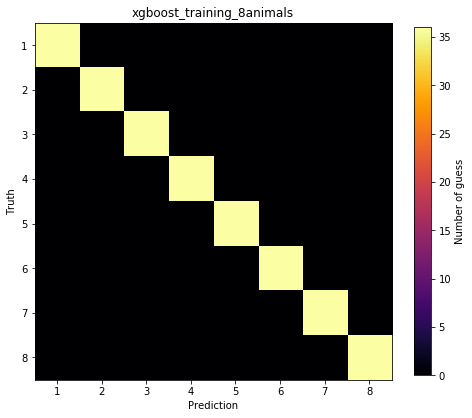

In [143]:
cm = confusion_matrix(y_train, prediction_x_train)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap = "inferno")
plt.colorbar(shrink=0.8).set_label('Number of guess')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.title('xgboost_training_8animals')
plt.xticks(np.arange(8))
plt.gca().set_xticklabels(np.arange(1,9))
plt.yticks(np.arange(8))
plt.gca().set_yticklabels(np.arange(1,9))
# plt.xticks(np.arange(1,13))
#plt.savefig('cm_train_e5000_lr0.5_15hidden.png')
#ax.plot([0, 1], [0, 1], transform=ax.transAxes)

In [105]:
prediction.shape

(48,)

[Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5'),
 Text(0,0,'6'),
 Text(0,0,'7'),
 Text(0,0,'8')]

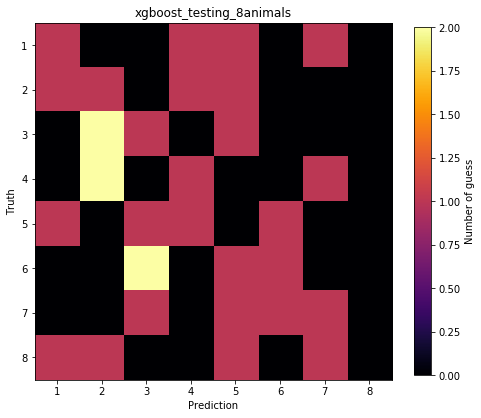

In [144]:
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap = "inferno")
plt.colorbar(shrink=0.8).set_label('Number of guess')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.title('xgboost_testing_8animals')
plt.xticks(np.arange(8))
plt.gca().set_xticklabels(np.arange(1,9))
plt.yticks(np.arange(8))
plt.gca().set_yticklabels(np.arange(1,9))
# plt.xticks(np.arange(1,13))
#plt.savefig('cm_train_e5000_lr0.5_15hidden.png')
#ax.plot([0, 1], [0, 1], transform=ax.transAxes)

In [156]:
def wavefunc_cross_validation (subject, animals):
    """ This function is just the wavefunc with cross-validation built-in"""   
    acc = []
    for i in range(10):
        acc.append(wavefunc(subject,animals,i))

    acc =  np.asarray(acc)
    return acc

In [158]:
# Now I would like to loop over all the subjects, and all the animal pairs.

subjects = np.arange(18) # 0-17 ; 18 subjects.

#levels = np.arange (5) # 0-4; 5 levels.

#animals = np.arange(1,13)

# A Python program to print all 
# combinations of given list

#from itertools import combinations 

# Get all combinations of [1, 2, 3] 
# and length 2 
#animal_pairs = list(combinations(animals,2))

In [159]:
# Loop over each subject:
from tqdm import tqdm

data_all = []

for subject in tqdm(subjects):
    print subject
    #for level in levels:
    #for animal in animals:
    acc = wavefunc_cross_validation(subject, animals)
    #if (animal_pair[0]-1)//4 == (animal_pair[1]-1)//4:
        #within = 1
    #else:
        #within = 0
    result_dict = {
        "subject": subject,
        #"level": level,
        #"animal1":animal_pair[0],
        #"animal2":animal_pair[1],
        "accuracy":acc,
        #"within":within
    }
    data_all.append(result_dict)

  0%|          | 0/18 [00:00<?, ?it/s]

0


  6%|▌         | 1/18 [01:11<20:14, 71.41s/it]

1


 11%|█         | 2/18 [02:23<19:06, 71.65s/it]

2


 17%|█▋        | 3/18 [03:34<17:52, 71.48s/it]

3


 22%|██▏       | 4/18 [04:45<16:39, 71.39s/it]

4


 28%|██▊       | 5/18 [05:55<15:20, 70.83s/it]

5


 33%|███▎      | 6/18 [07:07<14:13, 71.10s/it]

6


 39%|███▉      | 7/18 [08:17<12:59, 70.83s/it]

7


 44%|████▍     | 8/18 [09:28<11:48, 70.87s/it]

8


 50%|█████     | 9/18 [10:39<10:39, 71.05s/it]

9


 56%|█████▌    | 10/18 [11:49<09:24, 70.61s/it]

10


 61%|██████    | 11/18 [13:04<08:23, 71.89s/it]

11


 67%|██████▋   | 12/18 [14:13<07:07, 71.20s/it]

12


 72%|███████▏  | 13/18 [15:24<05:54, 70.91s/it]

13


 78%|███████▊  | 14/18 [16:33<04:41, 70.47s/it]

14


 83%|████████▎ | 15/18 [17:44<03:31, 70.66s/it]

15


 89%|████████▉ | 16/18 [18:54<02:21, 70.58s/it]

16


 94%|█████████▍| 17/18 [20:04<01:10, 70.25s/it]

17


100%|██████████| 18/18 [21:14<00:00, 70.83s/it]


In [171]:
from scipy import stats

for i in range(13):
    a = stats.ttest_1samp(data_all[i]['accuracy'],0.125)
    print a

Ttest_1sampResult(statistic=0.528680532637681, pvalue=0.6098151567906137)
Ttest_1sampResult(statistic=-1.8676290524384016, pvalue=0.0946557058284371)
Ttest_1sampResult(statistic=0.20751433915982165, pvalue=0.8402276669135297)
Ttest_1sampResult(statistic=-1.1677484162422846, pvalue=0.27291221509403707)
Ttest_1sampResult(statistic=0.40824829046386335, pvalue=0.6926333242322502)
Ttest_1sampResult(statistic=0.0, pvalue=1.0)
Ttest_1sampResult(statistic=-0.390566732942472, pvalue=0.7052012581661721)
Ttest_1sampResult(statistic=-1.488558185333922, pvalue=0.17078261244619522)
Ttest_1sampResult(statistic=1.44463023702923, pvalue=0.18246001075133464)
Ttest_1sampResult(statistic=-1.394971664925831, pvalue=0.196490374935594)
Ttest_1sampResult(statistic=0.34874291623145814, pvalue=0.7353018404227665)
Ttest_1sampResult(statistic=-0.8181818181818178, pvalue=0.4343801970835003)
Ttest_1sampResult(statistic=0.0, pvalue=1.0)


In [153]:
df = pd.DataFrame(data_all)
df.to_csv("classification_BA17_alllevels_8animals_xgboost.csv", index=True) 